# Uploading 15 scenes dataset

In [9]:

import numpy as np
import os
import glob
#from keras.preprocessing.image import ImageDataGenerator
import cv2
from os.path import join as join_path
import pdb
from collections import defaultdict
from skimage.transform import resize
#import shutil
import scipy.ndimage as ndimage
kernel = np.ones((7,7), np.uint8) 
allowed_extensions = ['*.png', '*.jpg', '*.jpeg', '*.bmp','*.mat','*.tif']

#abspath = os.path.dirname(os.path.abspath(__file__))

save = True

def read_training_data_4classification(base_dir):
        
    d = defaultdict(list)
    for root, subdirs, files in os.walk(base_dir):
        for filename in files:
            file_path = os.path.join(root, filename)
            assert file_path.startswith(base_dir)
            suffix = file_path[len(base_dir):]
            suffix = suffix.lstrip("\\")
            label = suffix.split("\\")[0]
            d[label].append(file_path)
      
    tags = sorted(d.keys())
    processed_image_count = 0
    useful_image_count = 0

    X = []
    y = []
    
    #pdb.set_trace()    
    for class_index, class_name in enumerate(tags):
        filenames = d[class_name]
        for filename in filenames:
            processed_image_count += 1         
            img = cv2.imread(filename)
            img_name_1 = filename.split('\\')[-1]
            img_name = img_name_1.split('.')[0]
            img_extension = img_name_1.split('.')[1]
            
            if img_extension =='jpg':
                img= np.array(img)               
                img = cv2.resize(img, (32,32), interpolation = cv2.INTER_AREA)
                X.append(img)
                y.append(class_index)                
                useful_image_count += 1       

    X = np.array(X).astype(np.float32)
    X=X.transpose((0,1,2,3))
    X = preprocess_input(X)
    y = np.array(y)

    perm = np.random.permutation(len(y))
    X = X[perm]
    y = y[perm]
    
    print("classes:")
    for class_index, class_name in enumerate(tags):
        print(class_name, sum(y == class_index))
    
    print("\n")

    return X, y, tags
    

In [10]:
from keras.applications.imagenet_utils import preprocess_input
data_X, data_y, tags = read_training_data_4classification('15-Scene') 


classes:
00 216
01 241
02 311
03 210
04 289
05 360
06 328
07 260
08 308
09 374
10 410
11 292
12 356
13 215
14 315




# Splitting the data (0.7 = Training and 0.3 = Testing)

In [11]:
import keras
import keras.utils
import sklearn
from sklearn.model_selection import cross_validate
import sklearn.metrics
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras import utils as np_utils
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Activation, MaxPool2D, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [12]:
#data_x, data_y = read_training_data_4classification('15_Scene_dataset', 32, 32)
import numpy as np
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.3, train_size=0.7, random_state=101)
print(X_train, 'train samples - X')
print(X_test, 'test samples - X')
print(y_train, 'train samples - Y')
print(y_test, 'test samples - Y')
print(X_train.shape[0], 'shape train samples - X')
print(X_test.shape[0], 'shape test samples - Y')





[[[[-3.6939003e+01 -4.9778999e+01 -5.6680000e+01]
   [-1.8939003e+01 -3.1778999e+01 -3.8680000e+01]
   [-9.9390030e+00 -2.2778999e+01 -2.9680000e+01]
   ...
   [-1.9390030e+00 -1.4778999e+01 -2.1680000e+01]
   [-1.4939003e+01 -2.7778999e+01 -3.4680000e+01]
   [-2.9939003e+01 -4.2778999e+01 -4.9680000e+01]]

  [[-8.3939003e+01 -9.6778999e+01 -1.0368000e+02]
   [-7.8939003e+01 -9.1778999e+01 -9.8680000e+01]
   [-7.3939003e+01 -8.6778999e+01 -9.3680000e+01]
   ...
   [-6.6939003e+01 -7.9778999e+01 -8.6680000e+01]
   [-7.1939003e+01 -8.4778999e+01 -9.1680000e+01]
   [-7.5939003e+01 -8.8778999e+01 -9.5680000e+01]]

  [[-7.4939003e+01 -8.7778999e+01 -9.4680000e+01]
   [-6.8939003e+01 -8.1778999e+01 -8.8680000e+01]
   [-6.1939003e+01 -7.4778999e+01 -8.1680000e+01]
   ...
   [-3.0939003e+01 -4.3778999e+01 -5.0680000e+01]
   [-5.2939003e+01 -6.5778999e+01 -7.2680000e+01]
   [-6.1939003e+01 -7.4778999e+01 -8.1680000e+01]]

  ...

  [[-4.0939003e+01 -5.3778999e+01 -6.0680000e+01]
   [-5.8939003e+

# Classes, batches , epochs

In [13]:

batch_size = 32
num_classes=15
epochs = 50
data_augmentation = True
num_predictions = 20

# Convert class vectors to binary class matrices

In [14]:
import numpy as np

#y_train=np.array(y_train)
#y_test=np.array(y_test)
# Convert class vectors to binary class matrices.

y_train = keras.utils.to_categorical(y_train, num_classes=15)
y_test = keras.utils.to_categorical(y_test, num_classes=15)

y_train.shape
y_test.shape
y_train[0]
y_test[0]


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
      dtype=float32)

# DCNN model

In [15]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from matplotlib import pyplot
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.layers import GlobalAveragePooling2D



weight_decay = 1e-4

model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay), input_shape=X_train.shape[1:]))
kernel_initializer=tf.contrib.layers.xavier_initializer()
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay)))
kernel_initializer=tf.contrib.layers.xavier_initializer()
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay)))
kernel_initializer=tf.contrib.layers.xavier_initializer()
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay)))
kernel_initializer=tf.contrib.layers.xavier_initializer()
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay)))
kernel_initializer=tf.contrib.layers.xavier_initializer()
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay)))
kernel_initializer=tf.contrib.layers.xavier_initializer()
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(GlobalAveragePooling2D()) 
model.add(Dense(15, activation='softmax'))

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)       

 # Optimizing the model with ADAM

In [17]:
from keras import optimizers
opt = keras.optimizers.SGD(learning_rate=0.0001, decay=1e-6)
opt = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [18]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(X_train)

    # Fit the model on the batches generated by datagen.flow().
    history = model.fit_generator(datagen.flow(X_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(X_test, y_test))
    score = model.evaluate(X_train, y_train, verbose=0)
    print('Train loss:', score[0])
    print('Train accuracy:', score[1])

    

Using real-time data augmentation.

Epoch 1/50
99/99 [==============================] - 84s 848ms/step - loss: 2.1725 - accuracy: 0.2940 - val_loss: 3.3650 - val_accuracy: 0.1627
Epoch 2/50
99/99 [==============================] - 75s 763ms/step - loss: 1.6801 - accuracy: 0.4549 - val_loss: 3.0620 - val_accuracy: 0.2786
Epoch 3/50
99/99 [==============================] - 77s 777ms/step - loss: 1.5444 - accuracy: 0.4909 - val_loss: 2.2279 - val_accuracy: 0.3848
Epoch 4/50
99/99 [==============================] - 78s 786ms/step - loss: 1.4031 - accuracy: 0.5476 - val_loss: 1.7893 - val_accuracy: 0.4495
Epoch 5/50
99/99 [==============================] - 77s 775ms/step - loss: 1.3386 - accuracy: 0.5632 - val_loss: 1.4504 - val_accuracy: 0.5498
Epoch 6/50
99/99 [==============================] - 79s 795ms/step - loss: 1.2600 - accuracy: 0.5878 - val_loss: 1.5642 - val_accuracy: 0.5349
Epoch 7/50
99/99 [==============================] - 78s 788ms/step - loss: 1.2443 - accuracy: 0.6059 - val

In [19]:
score = model.evaluate(X_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])


Train loss: 0.45958858942977937
Train accuracy: 0.8649251461029053


In [20]:
print("Accuracy: %.2f%%" % (score[1]*100))

Accuracy: 86.49%


In [23]:
model.fit(X_test, y_test)
y_pred = model.predict(X_test)
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/1
1346/1346 [==============================] - 28s 21ms/step - loss: 0.7411 - accuracy: 0.7741
Test loss: 0.6333352756004277
Test accuracy: 0.8157503604888916


In [24]:
print("Accuracy: %.2f%%" % (score[1]*100))

Accuracy: 81.58%


# Graphs

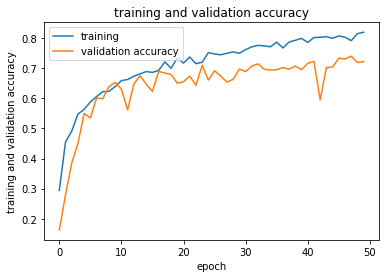

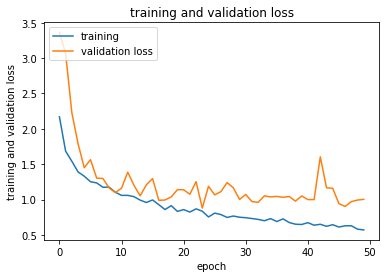

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot

fig = plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation accuracy'], loc = 'upper left')
plt.title('training and validation accuracy')
plt.ylabel('training and validation accuracy')
plt.xlabel('epoch')
plt.show()
fig.savefig('train_val_acc_01_01.png')


fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation loss'], loc = 'upper left')
plt.title('training and validation loss')
plt.ylabel('training and validation loss')
plt.xlabel('epoch')
plt.show()
fig.savefig('train_val_loss_01_01.png')

